### API

## Tools

### Web search & Scrapping

In [2]:
from typing import Annotated, List

from langchain_core.tools import tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=10)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """
    Scrape the provided web pages to extract detailed textual information.
    
    This function uses the WebBaseLoader to load and parse the content of the given URLs.
    It retrieves and processes the raw HTML, extracting readable text for further analysis.
    The results are returned as a single formatted string, where each web page's content
    is separated by line breaks for clarity.
    """
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"\n{doc.page_content}\n"
            for doc in docs
        ]
    )
    

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Text To Speech(TTS)

In [3]:
from pathlib import Path
from openai import OpenAI
from langchain_core.tools import tool

@tool
def text_to_speech(text: str, voice: str, output_filename: str) -> str:
    """
    Converts text to speech using OpenAI's TTS API, saving the audio file locally with a dynamic filename.

    Args:
        text (str): The text to convert to speech.
        voice (str): The voice model to use for speech synthesis. Options include:
                     - 'alloy', 'echo', 'fable', 'onyx', 'nova', 'shimmer'.
        output_filename (str): The name for the output audio file, including file extension (e.g., 'output.mp3').

    Returns:
        str: The path to the saved audio file.
    """
    client = OpenAI()
    speech_file_path = Path(output_filename)
    response = client.audio.speech.create(model='tts-1-hd', voice=voice, input=text)
    response.stream_to_file(speech_file_path)
    return str(speech_file_path)

### Combine given audio segments

In [4]:
from pydub import AudioSegment

@tool
def edit_podcast_audio(segments: List[str], pauses_between_segments: int = 100, output_filename: str = "final_podcast_episode.mp3") -> str:
    """
    Edits a podcast episode by combining audio segments with specified pauses between them, ensuring consistent volume.

    Args:
        segments (List[str]): List of paths to audio segment files.
        pauses_between_segments (int): Duration of pause between segments in milliseconds. Default is 1000.
        output_filename (str): The name for the output podcast file, including file extension (e.g., 'episode.mp3').

    Returns:
        str: The path to the saved podcast episode.
    """
    podcast_episode = AudioSegment.silent(duration=0) # Initialize an empty audio segment

    for segment_path in segments:
        segment = AudioSegment.from_file(segment_path)
        podcast_episode += AudioSegment.silent(duration=pauses_between_segments) + segment # Append with pause

    podcast_episode = podcast_episode.normalize() # Normalizer volume
    podcast_episode.export(output_filename, format='mp3')

    return output_filename

/usr/local/lib/python3.10/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [5]:
tools = [
    tavily_tool,
    scrape_webpages,
    text_to_speech,
    edit_podcast_audio
]

## Sub-agents & Supervisor agent

In [6]:
from typing import List, Optional

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

from langgraph.graph import StateGraph, START, END

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(acontent=result["messages"][-1].content, name=name)]}

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}"
            )
        ]
    ).partial(options=str(options), team_members=", ".join(members))

    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Research Team

In [34]:
import functools
import operator
from typing_extensions import TypedDict

from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent


class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

llm = ChatOpenAI(model="gpt-4o", max_tokens=10000)

# Team member(agent) : Search
search_system = """
You are a search specialist in a research team tasked with finding relevant and up-to-date information to support podcast content generation. Your primary tool is the Tavily search engine.

### Your Responsibilities:
1. **Understand the User's Request**:
   - Analyze the user's query or question to identify the key topics and intent.
2. **Formulate Precise Search Queries**:
   - Create effective and well-targeted search queries to maximize the quality and relevance of results.
3. **Utilize the Tavily Search Tool**:
   - Leverage the Tavily search engine to retrieve accurate and up-to-date information.
4. **Summarize Key Findings**:
   - Organize the most relevant information into clear and concise summaries tailored to the user’s request.
5. **Refine the Search Process** (if needed):
   - If the results are incomplete or lack relevance, refine your queries and perform additional searches to fill the gaps.

### Guidelines for Quality:
- **Accuracy**: Always ensure the information you provide is correct and backed by reliable sources.
- **Relevance**: Focus on information that directly addresses the user’s needs.
- **Transparency**: If no sufficient or satisfactory information is available, clearly communicate the limitations and suggest alternative approaches.

Your goal is to deliver search results that are not only accurate and relevant but also presented in a way that enhances the podcast creation process.
"""
search_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=search_system)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")


# Team member(agent) : WebScraper
webscraper_system = """
You are a web scraping specialist in a research team. Your primary role is to extract detailed and relevant information from specific web pages using the `scrape_webpages` tool.

### Your Responsibilities:
1. **Analyze the Provided URLs**:
   - Review and understand the URLs or web pages provided, often as a result of the Search agent's findings.
   - Identify the key sections or elements on the web pages that are most relevant to the research topic.

2. **Scrape Content Using the `scrape_webpages` Tool**:
   - Utilize the `scrape_webpages` tool to extract structured and unstructured data from the specified web pages.
   - Focus on capturing content that aligns directly with the research objectives.

3. **Process and Summarize Scraped Content**:
   - Organize and refine the extracted data to create clear, concise, and meaningful summaries.
   - Emphasize the most relevant information while removing irrelevant or redundant details.

4. **Handle Unsatisfactory Results**:
   - If the scraped content is incomplete or lacks relevance, propose alternative URLs or request refinements to the search query from the Search agent.
   - Document any limitations or challenges encountered during the scraping process.

### Guidelines for Ethical and Effective Web Scraping:
- **Respect Terms of Service**:
   - Ensure all scraping activities comply with the target website’s terms of service and legal regulations.
- **Ethical Practices**:
   - Avoid overloading servers or scraping restricted data.
- **Value-Added Content**:
   - Always summarize and contextualize the scraped data. Avoid returning raw or unprocessed content directly to the team.

Your ultimate goal is to provide high-quality, actionable insights that contribute to the research
"""
research_agent = create_react_agent(llm, tools=[scrape_webpages], state_modifier=webscraper_system)
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

# Research team superviosr
supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

### Research team graph

In [35]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END}
)
research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()

def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)]
    }
    return results

research_chain = enter_chain | chain

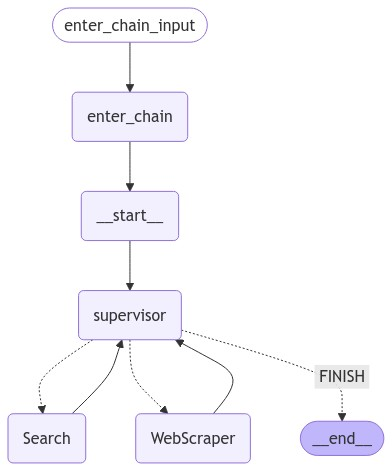

In [36]:
from IPython.display import Image, display

display(Image(research_chain.get_graph().draw_mermaid_png()))

## Podcast Team

In [37]:
class PodcastTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str
    script: List[dict]
    audio_segments: List[str]

# Team member(agent) : PodcastPlanner
podcast_plan_system="""
You are tasked with creating a well-structured script for a podcast episode in **KOREAN**. 
The script should simulate a natural conversation between the **host** and a **guest**, based on the provided topic and research information.

### **Key Requirements**:
1. **Dialogue Structure**:
   - The script must include interactions between at least two speakers: a **host** and a **guest**.
   - Alternate the dialogue segments between the host and guest to maintain a conversational flow.

2. **Speaker Identification**:
   - For each dialogue segment, specify clearly who is speaking (host or guest).

3. **Voice Model Assignment**:
   - Assign the appropriate text-to-speech voice model for each segment:
     - **Host**: Use the `'alloy'` voice model.
     - **Guest**: Use the `'fable'` voice model.

4. **Output Format**:
   - The output must be a **list of dictionaries**, where each dictionary contains the following keys:
     - `speaker`: The speaker's role (`host` or `guest`).
     - `text`: The speaker's dialogue in **KOREAN**.
     - `voice`: The assigned voice model (`'alloy'` or `'fable'`).

### **Example Output**:
```json
[
    {"speaker": "host", "text": "안녕하세요! 오늘은 기술의 최신 동향에 대해 이야기해 보겠습니다.", "voice": "alloy"},
    {"speaker": "guest", "text": "초대해 주셔서 감사합니다. 제 경험을 공유하게 되어 기쁩니다.", "voice": "fable"},
    {"speaker": "host", "text": "현재 진행 중인 프로젝트에 대해 말씀해 주실 수 있나요?", "voice": "alloy"},
    {"speaker": "guest", "text": "물론입니다! 저는 최근 새로운 AI 플랫폼 개발에 매진하고 있습니다...", "voice": "fable"}
]
"""
podcast_planner_agent = create_react_agent(
    llm, state_modifier=podcast_plan_system, tools=[tavily_tool]
)
podcast_planner_node = functools.partial(agent_node, agent=podcast_planner_agent, name="PodcastPlanner")

# Team member(agent) : AudioProducer
audio_producer_system="""
You are responsible for producing the final audio file for the podcast episode. 
Your task involves taking the structured script provided by the Podcast Planner and generating a seamless and professional-quality audio output.

### **Key Responsibilities**:
1. **Text-to-Speech Audio Generation**:
   - For each segment in the script:
     - Use the `text_to_speech` tool to generate audio, providing the specified `text` and `voice` model for each segment.
     - Save each segment as a separate audio file, ensuring the file naming reflects the segment order (e.g., `segment_01.wav`, `segment_02.wav`).

2. **Audio Editing and Combination**:
   - Use the `edit_podcast_audio` tool to combine all generated audio files into one cohesive podcast episode.
   - Ensure the segments are combined in the exact order provided in the script.
   - Add appropriate pauses between segments to create a natural conversation flow.

3. **Output Delivery**:
   - Save the final combined audio as a single podcast episode file.
   - Return the file path to the final podcast audio.

### **Guidelines for Quality**:
- **Accuracy**:
   - Ensure that the correct `text` and `voice` model are used for each segment as specified in the script.
- **Seamless Flow**:
   - Adjust timing and transitions to create a natural and engaging listening experience.
- **Professional Audio Standards**:
   - Ensure the audio output is clear, without noticeable gaps, overlaps, or inconsistencies.

### **Expected Output**:
- A single combined audio file representing the full podcast episode.
- The output should be the file path to this final audio file.

### **Example Workflow**:
1. Input Script:
```json
[
    {"speaker": "host", "text": "Welcome to our podcast!", "voice": "alloy"},
    {"speaker": "guest", "text": "Thank you for having me.", "voice": "fable"},
    {"speaker": "host", "text": "Let's dive into today's topic.", "voice": "alloy"}
]
"""
audio_producer_agent = create_react_agent(
    llm,
    [text_to_speech, edit_podcast_audio], state_modifier=audio_producer_system
)
audio_producer_node = functools.partial(agent_node, agent=audio_producer_agent, name="AudioProducer")

# Podcast tema supervisor
podcast_supervisor = create_team_supervisor(
    llm,
    """You are a supervisor tasked with managing the podcast creation process.
    Your team consists of a PodcastPlanner and an AudioProducer.
    Given the current state, decide which team member should act next or if the process is complete.
    Respond with 'PodcastPlanner', 'AudioProducer', or 'FINISH'.""",
    ["PodcastPlanner", "AudioProducer"]
)

### Podcast team graph

In [38]:
podcast_graph = StateGraph(PodcastTeamState)

podcast_graph.add_node("PodcastPlanner", podcast_planner_node)
podcast_graph.add_node("AudioProducer", audio_producer_node)
podcast_graph.add_node("supervisor", podcast_supervisor)

podcast_graph.add_edge("PodcastPlanner", "supervisor")
podcast_graph.add_edge("AudioProducer", "supervisor")
podcast_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"PodcastPlanner": "PodcastPlanner", "AudioProducer": "AudioProducer", "FINISH": END},
)
podcast_graph.add_edge(START, "supervisor")

chain = podcast_graph.compile()

def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["PodcastPlanner", "AudioProducer"],
        "next": "",
        "script": [],
        "audio_segments": []
    }
    return results

podcast_chain = enter_chain | chain

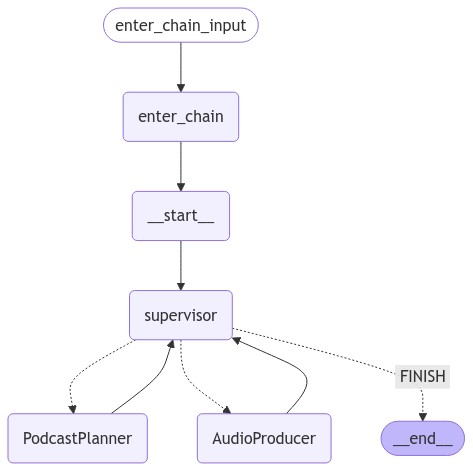

In [39]:
from IPython.display import Image, display

display(Image(podcast_chain.get_graph().draw_mermaid_png()))

## Supervisor definition in upper layer

In [40]:
llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PodcastTeam"],
)

### Upper layer graph

In [41]:
class UpperState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: UpperState) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


super_graph = StateGraph(UpperState)

super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node("PodcastTeam", get_last_message | podcast_chain | join_graph)
super_graph.add_node("supervisor", supervisor_node)

super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PodcastTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PodcastTeam": "PodcastTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

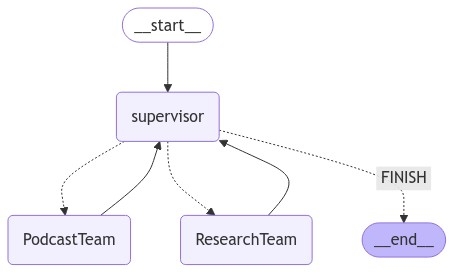

In [42]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

## Run

In [43]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="브르즈칼리파 옥상에서 계란을 떨어뜨려도 안깨질 수 있는 포장 구조 설계 방법에 대한 대화 (현재: 2024년 11월 27일)"
            )
        ]
    },
    {"recursion_limit": 150}
):
    if "__end__" not in s:
        print(s)
        print("-" * 40)

{'supervisor': {'next': 'ResearchTeam'}}
----------------------------------------
{'ResearchTeam': {'messages': [HumanMessage(content='브르즈 칼리파 옥상에서 계란을 떨어뜨려도 깨지지 않게 하기 위한 포장 구조 설계에 대한 정보를 다음과 같이 요약할 수 있습니다:\n\n1. **충격 완화 구조 설계**:\n   - 계란을 중심으로 충격을 최대한 분산시키는 구조를 만드는 것이 중요합니다. 이를 위해 정육면체 구조 등의 공간 내에서 충격을 흡수할 수 있는 물질(예: 종이, 스펀지)을 활용할 수 있습니다.\n   - [Prezi](https://prezi.com/iryovhmmk7ob/presentation/)에서 제안된 방법은 충격을 가능한 최대한 분산시킬 수 있는 구조물을 만드는 것입니다.\n\n2. **공기 저항 활용**:\n   - 계란 낙하시 공기 저항을 극대화하여 낙하 속도를 줄이는 방법도 효과적입니다. 예를 들어, 빨대와 테이프를 사용하여 공기 저항을 증가시키는 구조를 설계할 수 있습니다. [HotThott 블로그](https://hotthott.tistory.com/31)에서는 이런 방법을 사용해 5층 높이에서 성공적으로 계란을 보호한 사례가 있습니다.\n\n3. **완충재 사용**:\n   - 계란 주위에 종이 등을 구겨 넣어 완충재 역할을 하도록 하여 충격을 흡수하게 할 수 있습니다. [Prezi](https://prezi.com/1qs1b62cbldw/presentation/)에서 이러한 방법이 제안되었습니다.\n\n4. **운동량과 충격량의 이해**:\n   - 계란의 낙하 충격을 줄이기 위해서는 충격량 공식을 활용하여 충격을 받는 시간을 늘리거나 충격을 분산시켜야 합니다. [네이버 블로그](https://m.blog.naver.com/ssy2205/222691860377)에서는 이를 통해 충격력을 줄이는 방법을 설명하고 있습니다.\n\n이

/tmp/ipykernel_78503/773177328.py:22: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)


{'PodcastTeam': {'messages': [HumanMessage(content='The final combined podcast episode has been created successfully. You can find the audio file at the following path: `final_podcast_episode.wav`.', additional_kwargs={}, response_metadata={}, name='AudioProducer')]}}
----------------------------------------
{'supervisor': {'next': 'PodcastTeam'}}
----------------------------------------
{'PodcastTeam': {'messages': [HumanMessage(content='The final combined podcast episode has been created successfully. You can find the audio file at the following path: `final_podcast_episode.wav`.', additional_kwargs={}, response_metadata={})]}}
----------------------------------------
{'supervisor': {'next': 'FINISH'}}
----------------------------------------
